# Compliance

In [1]:
import numpy as np
import torch

In [2]:
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [4]:
from scipy.integrate import simps
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [5]:
import sys
sys.path.insert(0, './python')

In [6]:
def plot_x_y(x, y, x_label="x", y_label="y"):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x, y)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [7]:
def print_model_params(wk_model):
    print("Параетры модели: ")
    print("R:\t%.2f" % test_model.R)
    print("Z_0:\t%.4f" % test_model.Z_0)
    print("C:\t%.2f" % test_model.C)
    print("P_out:\t%.2f" % test_model.P_out)

In [8]:
from windkessel import model, utils

In [9]:
import re
from os import listdir

filenames = listdir("./data")
IDs = [int(filename[0:-4]) for filename in filenames if re.match(r".*\.csv$", filename)]

## Данные о пациентах

In [10]:
def prepare_data(data_frame):
    data_frame = data_frame[data_frame.index.notnull()]
    data_frame.index = data_frame.index.astype('uint64')
    data_frame = data_frame.drop(columns=["ФИО"])
    return data_frame

In [11]:
data_patients = prepare_data(pd.read_excel(f'data/data_patients.xlsx', index_col="ID"))
data_PWV = prepare_data(pd.read_excel(f'data/data_PWV.xlsx', index_col="ID"))

In [12]:
data_patients = data_patients[data_patients.index.isin(IDs)]
data_patients = data_patients.join(data_PWV["PWV_ba"])

In [13]:
data_patients["SV"] = data_patients["ФВ"] * data_patients["КДО"] / 100.0

In [14]:
data_patients.head()

,№,дата,Возраст,Пол,Рост,Вес,ИМТ,ЧСС,E,A,...,RB САД,LB САД,RA САД,LA САД,RB ДИА,LB ДИА,RA ДИА,LA ДИА,PWV_ba,SV
ID,,,,,,,,,,,,,,,,,,,,,
123313,147.0,2019-11-29,31.0,1.0,171.0,86.0,29.5,72.0,112.0,70.0,...,96.0,97,97.0,100.0,77.0,78.0,74.0,76.0,6.582915,31.92
123645,151.0,2019-12-04,44.0,1.0,170.0,100.0,34.6,71.0,77.0,61.0,...,95.0,97,98.0,109.0,80.0,86.0,74.0,77.0,5.603448,73.92
124235,155.0,2019-12-11,23.0,1.0,183.0,68.0,20.3,56.0,78.0,45.0,...,89.0,92,83.0,86.0,71.0,71.0,59.0,67.0,6.194690,60.48
124238,156.0,2019-12-11,23.0,1.0,190.0,100.0,27.7,48.0,135.0,62.0,...,84.0,95q,82.0,91.0,62.0,73.0,55.0,61.0,5.530303,73.92
124625,165.0,2019-12-16,71.0,2.0,156.0,78.0,32.1,73.0,58.0,81.0,...,114.0,110,117.0,113.0,95.0,86.0,85.0,80.0,10.084746,35.88


## Получение ёмкостей

In [15]:
def get_C(patient_id):
    print(patient_id)
    
    # Создание модели.
    wk_model = model.WindkesselModel()
    
    # Получение данных.
    tp = pd.read_csv(f'data/{patient_id}.csv', header = None, sep = ' ')
    
    # t в секундах, p в мм.рт.ст.
    tp = tp.rename({0 :'t', 1: 'p'}, axis = 1)
    tp = tp.sort_values(by=['t'])
    
    T = np.array(tp['t'])
    P = np.array(tp['p'])
    
    # Фильтрация.
    n_points = 200
    interp1d_params = {}
    savgol_filter_params = {"window_length": 9, "polyorder": 3, "mode": "nearest"}

    T, P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
            interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)

    # Производная.
    savgol_filter_params["deriv"] = 1
    T, der_P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
            interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)
    
    wk_model.set_P(T, P, der_P)
    
    # Подсчёт RC
    P_0, RC, P_out = wk_model.get_exp_param()
    #wk_model.P_out = P_out
    
    # Подсчёт C по SV.
    C_SV = wk_model.get_C_from_SV(data_patients["SV"][patient_id])
    
    # Подсчёт R по SV.
    R_SV = wk_model.get_R_from_SV(data_patients["SV"][patient_id])
    
    # ДИКИЙ СПОСОБ через минимизацию функционала.
    max_dt = (wk_model.T[-1] - wk_model.T[0]) / 100
    def Q_in_rhs(t, Q_in):
        return wk_model.Q_in_rhs(t, Q_in)#.detach().numpy()
    
    def calc_SV(T, Q_in):
        return simps(Q_in, T)
    
    def zero_Q_in_functional(x):
        wk_model.C = x[0]
        wk_model.R = RC / wk_model.C

        # Получение Q_in.
        result = solve_ivp(Q_in_rhs, (wk_model.T[0], wk_model.T[-1]), np.array([0.0]),
                           t_eval=wk_model.T, max_step=max_dt, rtol=1.0)
        Q_in = result.y[0]

        # Получение расчётного времени, начиная с которого поток должен быть нулевым.
        eds_index, eds_time = wk_model.get_exp_decay_start()

        # Значение функционала.
        _SV = calc_SV(T, Q_in)
        value = (np.mean(np.abs(Q_in[eds_index:])) * (T[1] - T[0]))**2 + (_SV - data_patients["SV"][patient_id])**2
        # + 0.1 * (test_model.R - 0.5)**2

        return value
    
    x0 = (C_SV)
    minimize(zero_Q_in_functional, x0=x0, bounds=[(0.01, 100.0)])
    
    return [C_SV, RC / R_SV, wk_model.C]

In [16]:
params = np.array([get_C(patient_id) for patient_id in data_patients.index])
data_patients["C_SV"] = params[:,0]
data_patients["C_R_SV"] = params[:,1]
data_patients["func_C"] = params[:,2]

123313
123645


/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


124235
124238
124625
124627
124871
124942
130589
130166
130469
131003
131255
131663
131658
143725
143922
145789
145796
144957
144726
146300
144237
146798
144717
147382
146896
146887
147393
147394
143846
144777
147541
147728
147549
147738
147790
147793
147953
148193
148272
148202
148343
148348
148353
148413
148426
148795
149160
149217
149222
149280
149604
149671
149718
149669
150445
150447
150529
150535


### Скорость пульсовой волны

Text(0, 0.5, 'PWV')

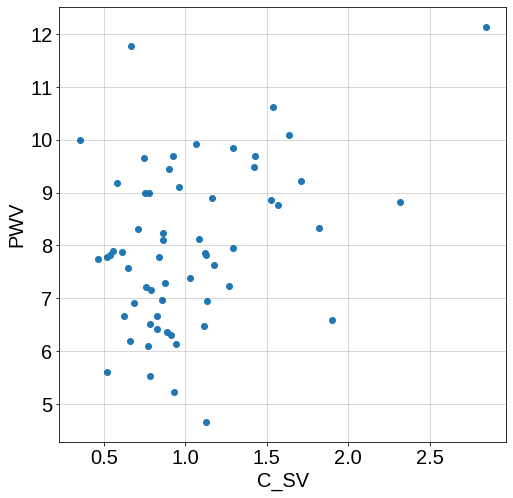

In [17]:
fig = plt.figure()
ax = fig.gca()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.scatter(data_patients["C_SV"], data_patients["PWV_ba"])

ax.set_xlabel("C_SV")
ax.set_ylabel("PWV")

Text(0, 0.5, 'PWV')

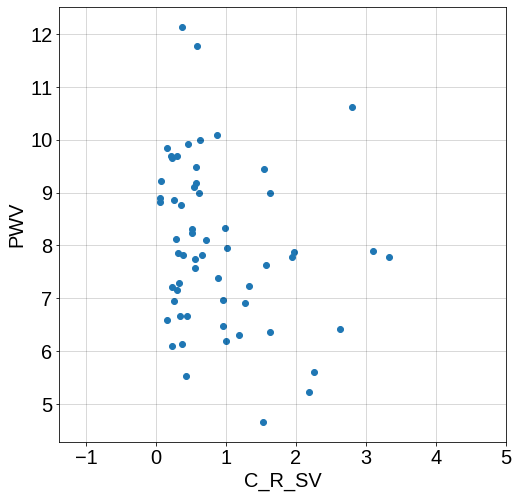

In [18]:
fig = plt.figure()
ax = fig.gca()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.scatter(data_patients["C_R_SV"], data_patients["PWV_ba"])
ax.set_xlim(right=5.0)

ax.set_xlabel("C_R_SV")
ax.set_ylabel("PWV")

Text(0, 0.5, 'PWV')

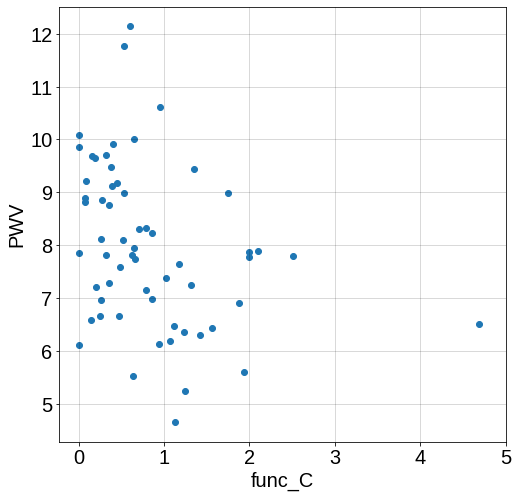

In [19]:
fig = plt.figure()
ax = fig.gca()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.scatter(data_patients["func_C"], data_patients["PWV_ba"])
ax.set_xlim(right=5.0)

ax.set_xlabel("func_C")
ax.set_ylabel("PWV")

### Возраст

Text(0, 0.5, 'Возраст')

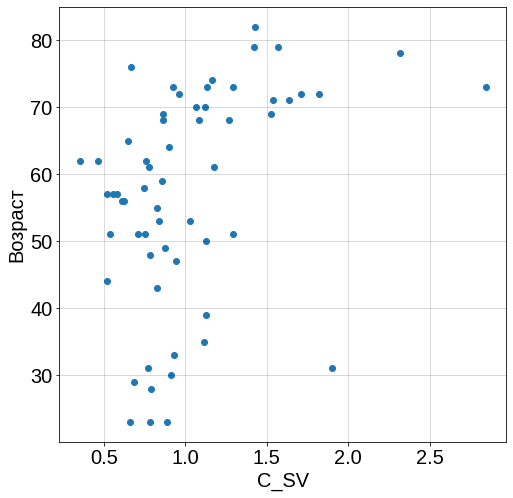

In [27]:
fig = plt.figure()
ax = fig.gca()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.scatter(data_patients["C_SV"], data_patients["Возраст"])

ax.set_xlabel("C_SV")
ax.set_ylabel("Возраст")

Text(0, 0.5, 'Возраст')

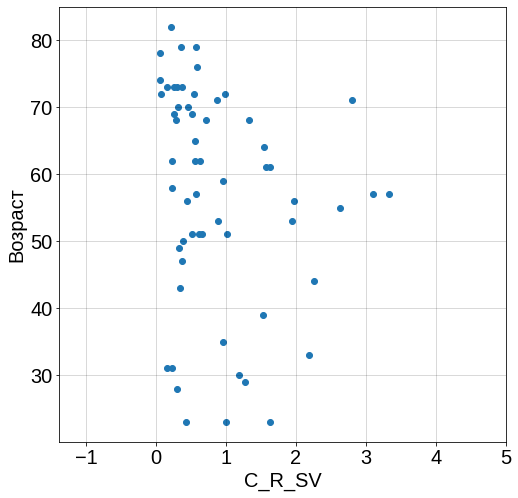

In [25]:
fig = plt.figure()
ax = fig.gca()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.scatter(data_patients["C_R_SV"], data_patients["Возраст"])
ax.set_xlim(right=5.0)

ax.set_xlabel("C_R_SV")
ax.set_ylabel("Возраст")

Text(0, 0.5, 'Возраст')

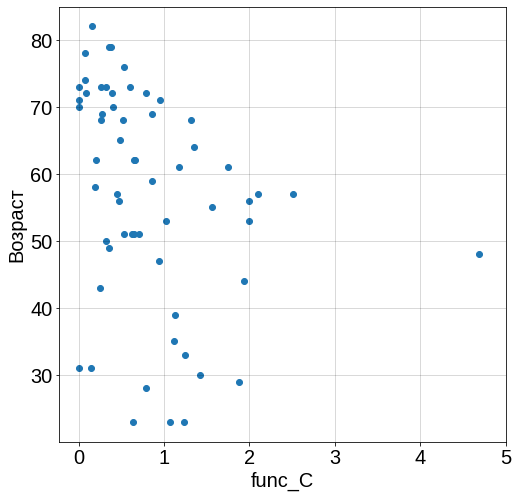

In [26]:
fig = plt.figure()
ax = fig.gca()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.scatter(data_patients["func_C"], data_patients["Возраст"])
ax.set_xlim(right=5.0)

ax.set_xlabel("func_C")
ax.set_ylabel("Возраст")

In [28]:
data_patients[["Возраст", "PWV_ba", "C_SV", "C_R_SV", "func_C"]].corr()

,Возраст,PWV_ba,C_SV,C_R_SV,func_C
Возраст,1.000000,0.739015,0.379184,-0.113653,-0.316535
PWV_ba,0.739015,1.000000,0.362700,-0.167242,-0.325345
C_SV,0.379184,0.362700,1.000000,-0.125079,-0.332851
C_R_SV,-0.113653,-0.167242,-0.125079,1.000000,0.766375
func_C,-0.316535,-0.325345,-0.332851,0.766375,1.000000


In [29]:
data_patients[["Возраст", "PWV_ba", "C_SV", "C_R_SV", "func_C"]].corr(method='spearman')

,Возраст,PWV_ba,C_SV,C_R_SV,func_C
Возраст,1.000000,0.772004,0.439193,-0.342018,-0.451155
PWV_ba,0.772004,1.000000,0.252601,-0.242015,-0.371577
C_SV,0.439193,0.252601,1.000000,-0.329703,-0.397944
C_R_SV,-0.342018,-0.242015,-0.329703,1.000000,0.888037
func_C,-0.451155,-0.371577,-0.397944,0.888037,1.000000
